In [1]:
from models import ModelClassifier, C1AndC2Different, C1PositiveAndC2Negative, LogOddsRatio
import plot
from scipy.special import logit
from shap.maskers import Independent
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import shap
from matplotlib import pyplot
import numpy as np
import pandas as pd
from types import SimpleNamespace
import pickle
%matplotlib inline
shap.initjs()
notebook_name = 'Two Different Logistic Regression Classifiers'

# Two Different Logistic Regression Classifiers

In [2]:
X, y = shap.datasets.adult()
feature_names = list(X.columns)
n_features = len(feature_names)
display_data = shap.datasets.adult(display=True)[0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)
X_explain, y_explain, display_data_explain = \
    resample(X, y, display_data, n_samples=500, replace=False, stratify=y, random_state=0)

In [3]:
try:
    with open(f'data/{notebook_name}.clf.pickle', 'rb') as f:
        clf = pickle.load(f)
    print('loaded saved classifiers')
    with open(f'data/{notebook_name}.expl.pickle', 'rb') as f:
        expl = pickle.load(f)
    print('loaded saved explanations')
except FileNotFoundError:
    pass

loaded saved classifiers
loaded saved explanations


## Create Models

In [4]:
%%time
linear_model_a = LogisticRegression(C=1.0, max_iter=10000)
linear_model_a.fit(X_train, y_train)
linear_model_b = LogisticRegression(C=0.1, max_iter=10000)
linear_model_b.fit(X_train, y_train)
clf = SimpleNamespace(a=ModelClassifier(linear_model_a), b=ModelClassifier(linear_model_b))
with open(f'data/{notebook_name}.clf.pickle', 'wb') as f:
    pickle.dump(clf, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 33 s, sys: 3.06 s, total: 36.1 s
Wall time: 22.1 s


In [5]:
print(classification_report(clf.a.predict(X_test), y_test))

              precision    recall  f1-score   support

       False       0.93      0.87      0.90      5272
        True       0.56      0.70      0.62      1241

    accuracy                           0.84      6513
   macro avg       0.74      0.79      0.76      6513
weighted avg       0.86      0.84      0.84      6513



In [6]:
print(classification_report(clf.b.predict(X_test), y_test))

              precision    recall  f1-score   support

       False       0.93      0.87      0.90      5274
        True       0.56      0.70      0.62      1239

    accuracy                           0.84      6513
   macro avg       0.74      0.79      0.76      6513
weighted avg       0.86      0.84      0.84      6513



In [116]:
y_pred_different = lambda X: np.sum((clf.a.predict(X) != clf.b.predict(X))*1)
print(f'# predictions different in train: {y_pred_different(X_train)}/{X_train.shape[0]}')
print(f'# predictions different in test: {y_pred_different(X_test)}/{X_test.shape[0]}')
print(f'# predictions different in explain: {y_pred_different(X_explain)}/{X_explain.shape[0]}')

# predictions different in train: 29/26048
# predictions different in test: 6/6513
# predictions different in explain: 4/500


In [8]:
diff = SimpleNamespace()
diff.a_and_b_diff = C1AndC2Different(clf.a, clf.b)
diff.a_pos_and_b_neg = C1PositiveAndC2Negative(clf.a, clf.b)
diff.a_neg_and_b_pos = C1PositiveAndC2Negative(clf.b, clf.a)
diff.log_odds_ratio = LogOddsRatio(clf.a, clf.b)

## Generate Explanations

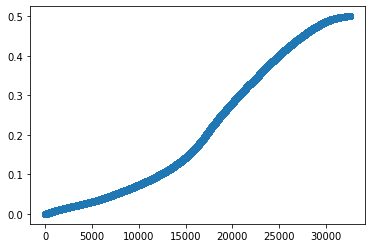

In [119]:
# TODO: explain instances, whose probabilities of a_and_b_diff >= 0.5 cutoff value (they should be the same as identified with y_pred_different)
# TODO: explain instances, sampled from X stratified across probabilities (or are log-odds not better suited?) of a_and_b_diff
# TODO: put those sets together or explain separately? is there a way to join them again?
# TODO: play around with different settings for background_data
distribution = diff.a_and_b_diff.predict_proba(X)[:, 1]
pyplot.plot(sorted(distribution), marker='o')
probabilities = distribution/sum(distribution)
indexes = np.random.choice(np.arange(0, X.shape[0]), size=500, p=probabilities)
X_explain = X.iloc[indexes]


In [9]:
def explain(function):
    predict_pos = lambda X: function(X)[:, 1]
    masker = Independent(data=X_explain)
    explainer = shap.Explainer(predict_pos, masker, feature_names=feature_names)
    shap_values = explainer(X_explain)
    shap_values.display_data = display_data_explain
    shap_values.expected_value = np.mean(predict_pos(X_explain))
    return shap_values

In [22]:
class SliceableNamespace(SimpleNamespace):
    def __getitem__(self, *args, **kwargs):
        return SliceableNamespace(**dict([(k, v.__getitem__(*args, **kwargs)) for k, v in self.__dict__.items()]))

In [23]:
%%time
expl = SliceableNamespace()
expl.proba = SliceableNamespace(**dict([(name, explain(model.predict_proba)) for name, model in (vars(clf) | vars(diff)).items() if hasattr(model, 'predict_proba')]))
expl.log_odds = SliceableNamespace(**dict([(name, explain(model.predict_log_odds)) for name, model in (vars(clf) | vars(diff)).items() if hasattr(model, 'predict_log_odds')]))
with open(f'data/{notebook_name}.expl.pickle', 'wb') as f:
    pickle.dump(expl, f, pickle.HIGHEST_PROTOCOL)

Permutation explainer: 501it [00:20, 11.85it/s]                         
Permutation explainer: 501it [00:20, 11.89it/s]                         
Permutation explainer: 501it [00:34, 10.18it/s]                         
Permutation explainer: 501it [00:33, 10.11it/s]                         
Permutation explainer: 501it [00:34, 10.20it/s]                         
Permutation explainer: 501it [00:21, 11.26it/s]                         
Permutation explainer: 501it [00:20, 12.02it/s]                         
Permutation explainer: 501it [00:35,  9.80it/s]                         
Permutation explainer: 501it [00:37,  9.27it/s]                         
Permutation explainer: 501it [00:36,  9.78it/s]                         
Permutation explainer: 501it [00:39,  8.87it/s]                         

CPU times: user 7min 54s, sys: 48.1 s, total: 8min 42s
Wall time: 5min 33s


## Analyze

### Feature Importance

First, sort features by their maximum contribution to the differences in probability space. The 95th percentile is used as the sorting criteria instead of the maximum in order not to be sensitive to outliers.

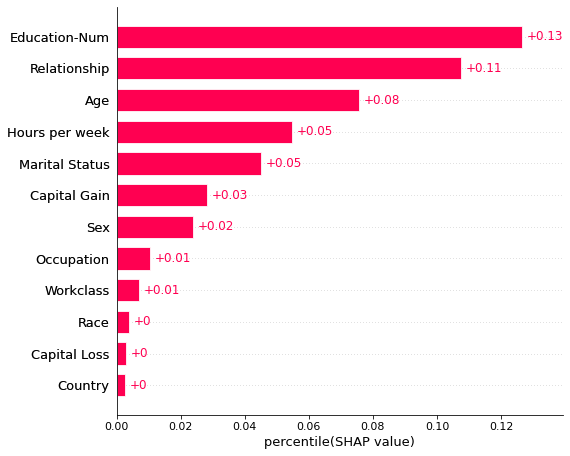

In [12]:
percentile_95th = expl.proba.a_and_b_diff.percentile(95, 0)
shap.plots.bar(percentile_95th, max_display=n_features)
feature_order = np.flip(percentile_95th.values.argsort())
features_sorted = np.array(feature_names)[feature_order]

### SHAP Value Distribution

In [13]:
kwargs = {'order': feature_order, 'max_display': n_features}

#### Probability Space

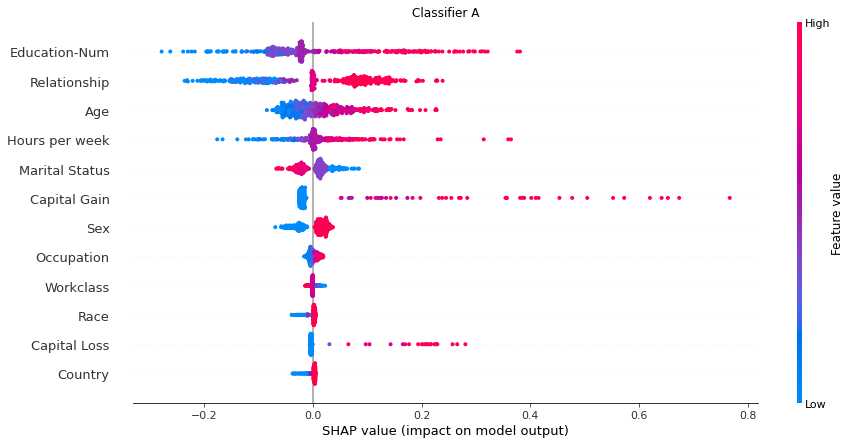

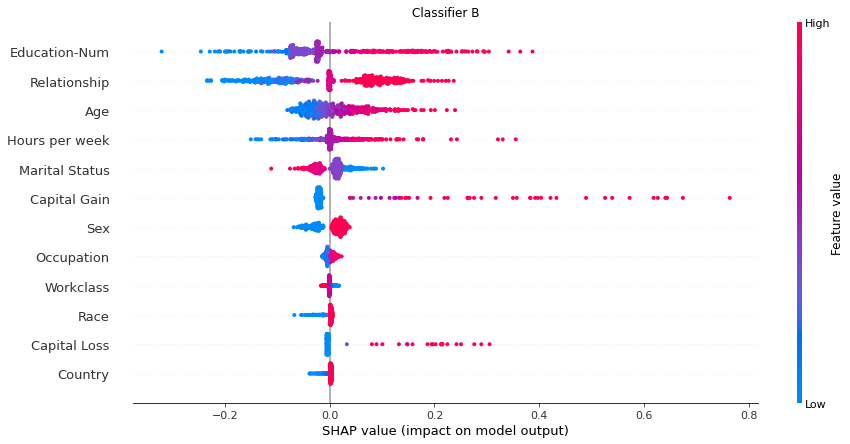

In [14]:
plot.shap_beeswarm(expl.proba.a, 'Classifier A', **kwargs)
plot.shap_beeswarm(expl.proba.b, 'Classifier B', **kwargs)

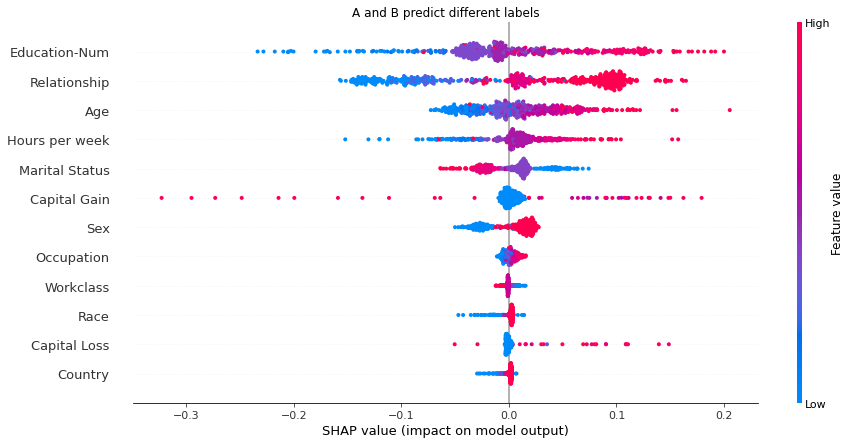

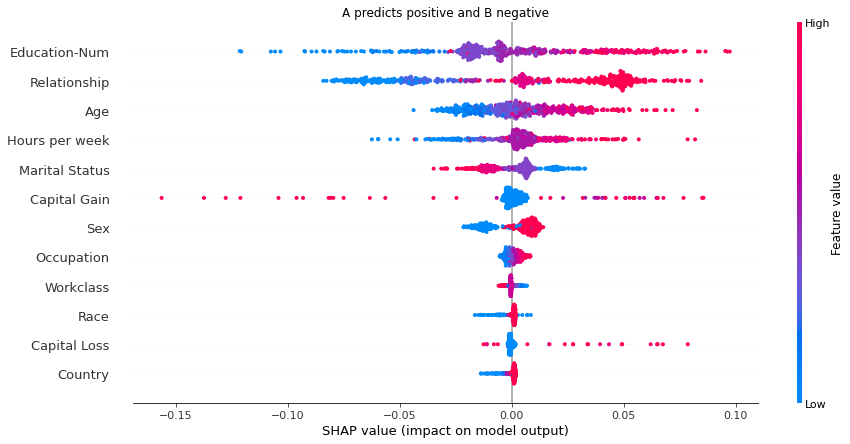

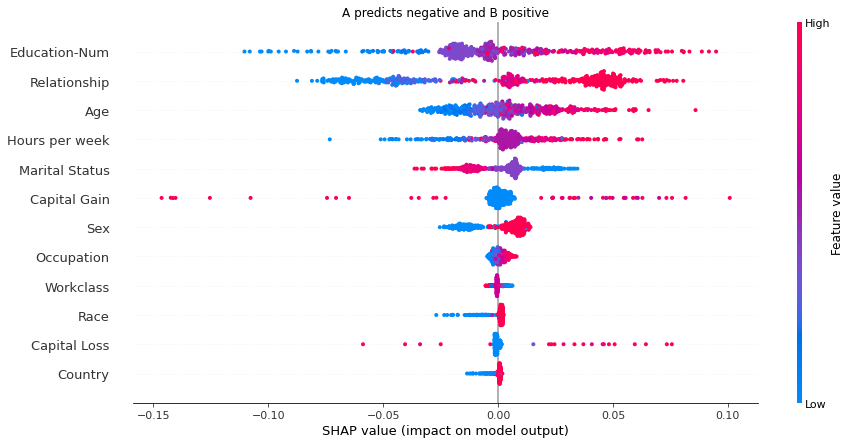

In [15]:
plot.shap_beeswarm(expl.proba.a_and_b_diff, 'A and B predict different labels', **kwargs)
plot.shap_beeswarm(expl.proba.a_pos_and_b_neg, 'A predicts positive and B negative', **kwargs)
plot.shap_beeswarm(expl.proba.a_neg_and_b_pos, 'A predicts negative and B positive', **kwargs)

#### Margin Space

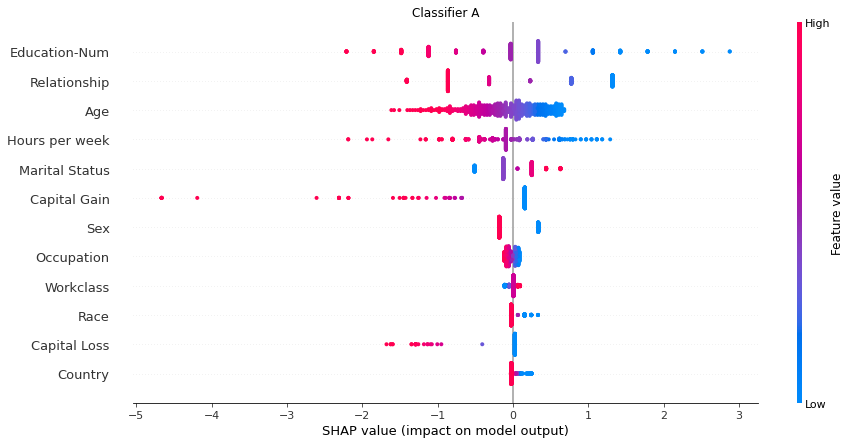

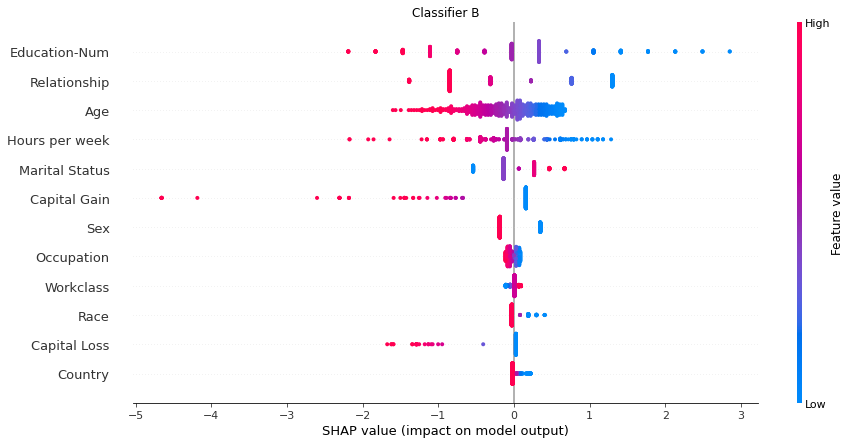

In [16]:
plot.shap_beeswarm(expl.log_odds.a[expl.log_odds.a.min(1).values > -8, :], 'Classifier A', **kwargs)
plot.shap_beeswarm(expl.log_odds.b[expl.log_odds.b.min(1).values > -8, :], 'Classifier B', **kwargs)

In [17]:
for index in np.where(expl.log_odds.a.min(1).values <= -8)[0]:
    plot.shap_force(expl.log_odds.a[index, :], f'Classifier A (observation #{index})')
for index in np.where(expl.log_odds.b.min(1).values <= -8)[0]:
    plot.shap_force(expl.log_odds.b[index, :], f'Classifier B (observation #{index})')

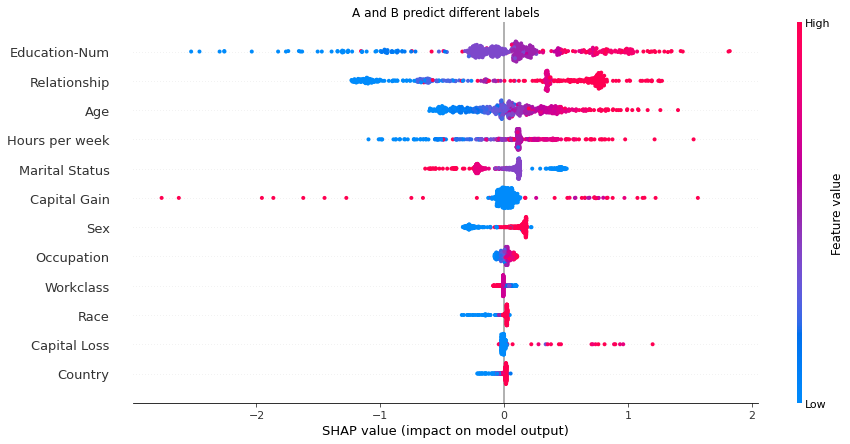

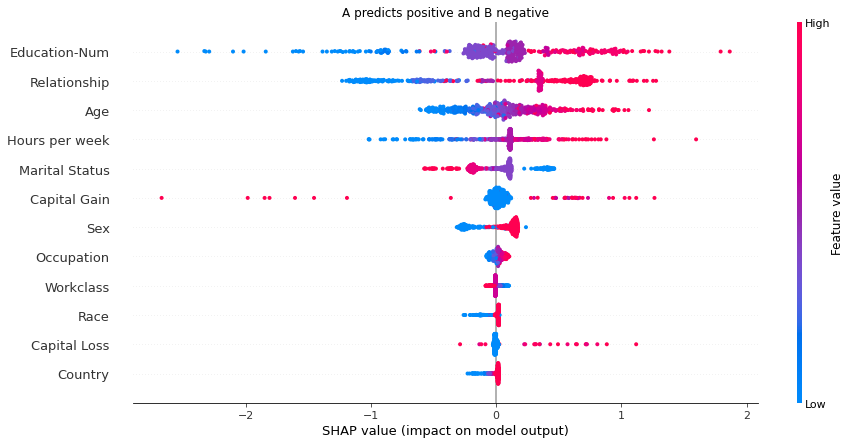

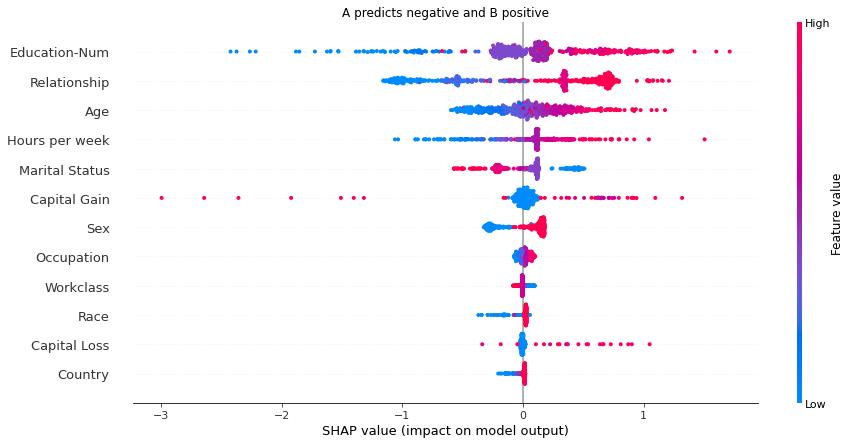

In [18]:
plot.shap_beeswarm(expl.log_odds.a_and_b_diff[expl.log_odds.a_and_b_diff.min(1).values > -8, :], 'A and B predict different labels', **kwargs)
plot.shap_beeswarm(expl.log_odds.a_pos_and_b_neg[expl.log_odds.a_pos_and_b_neg.min(1).values > -8, :], 'A predicts positive and B negative', **kwargs)
plot.shap_beeswarm(expl.log_odds.a_neg_and_b_pos[expl.log_odds.a_neg_and_b_pos.min(1).values > -8, :], 'A predicts negative and B positive', **kwargs)

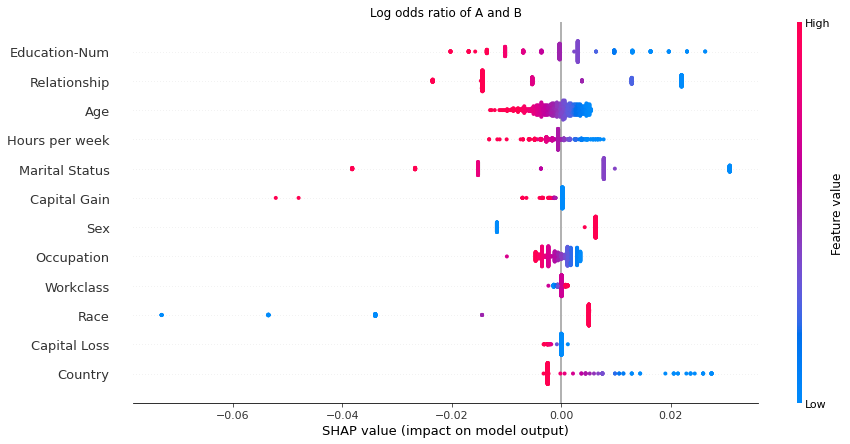

In [19]:
plot.shap_beeswarm(expl.log_odds.log_odds_ratio, 'Log odds ratio of A and B', **kwargs)

### Features' Partial Dependence Plots

#### Probability Space

##### Traditional Approach

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


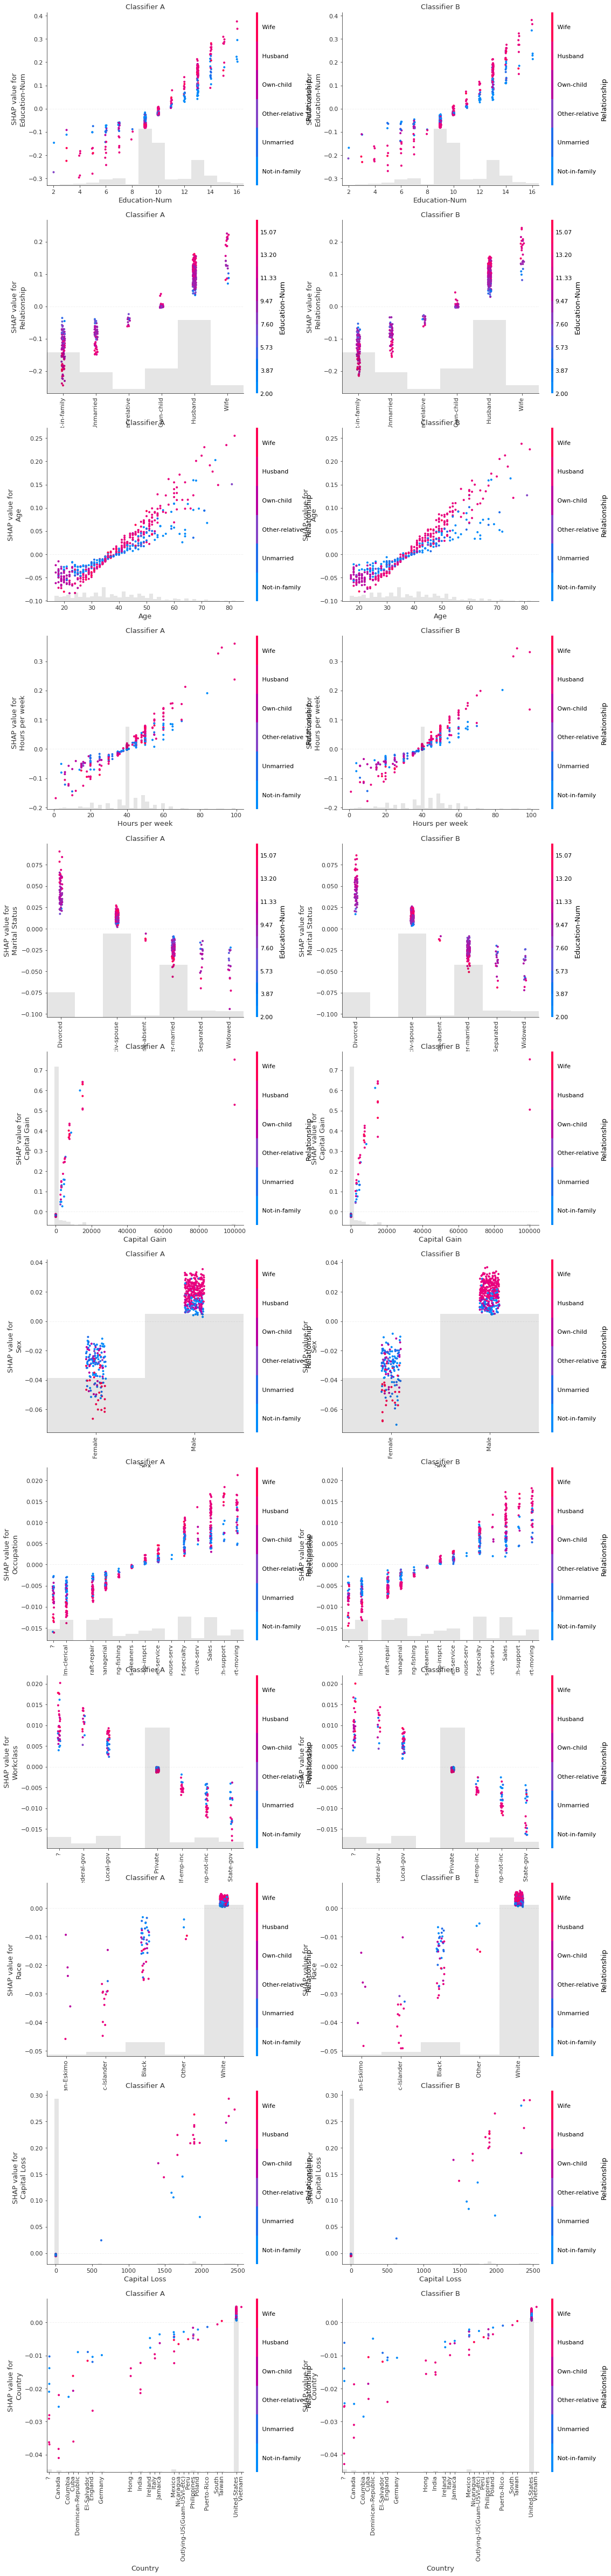

In [26]:
n_columns = 2
n_rows = n_features
fig = pyplot.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in features_sorted:
    ax = fig.add_subplot(n_rows, n_columns, i)
    plot.shap_scatter(expl.proba.a, feature, 'Classifier A', ax=ax)
    plot.shap_scatter(expl.proba.b, feature, 'Classifier B', ax=fig.add_subplot(n_rows, n_columns, i+1, sharey=ax))
    i += n_columns
pyplot.show()

##### Proposed Approach

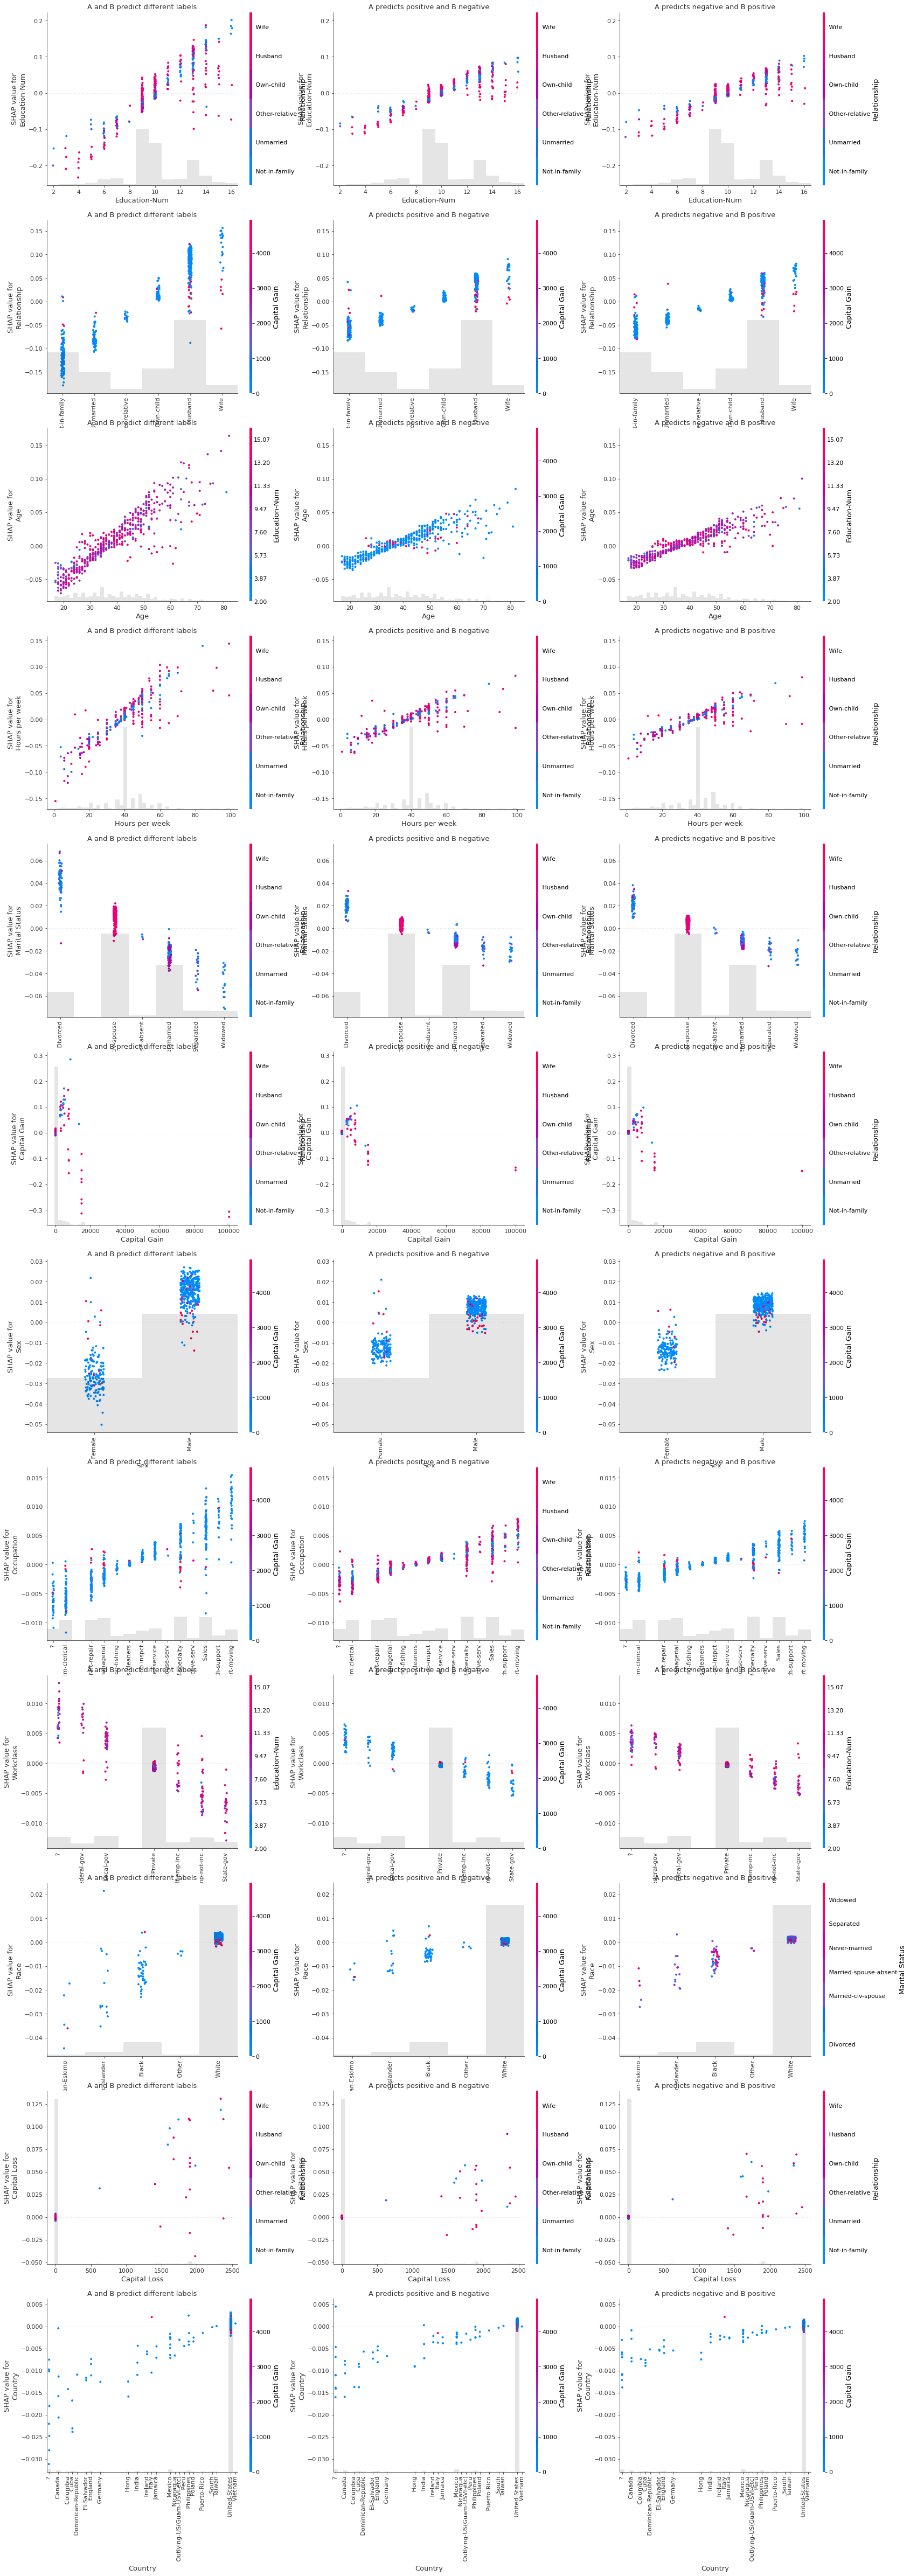

In [27]:
n_columns = 3
n_rows = n_features
fig = pyplot.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in features_sorted:
    ax = fig.add_subplot(n_rows, n_columns, i)
    plot.shap_scatter(expl.proba.a_and_b_diff, feature, 'A and B predict different labels', ax=ax)
    plot.shap_scatter(expl.proba.a_pos_and_b_neg, feature, 'A predicts positive and B negative', ax=fig.add_subplot(n_rows, n_columns, i+1, sharey=ax))
    plot.shap_scatter(expl.proba.a_neg_and_b_pos, feature, 'A predicts negative and B positive', ax=fig.add_subplot(n_rows, n_columns, i+2, sharey=ax))
    i += n_columns
pyplot.show()

#### Margin Space

##### Traditional Approach

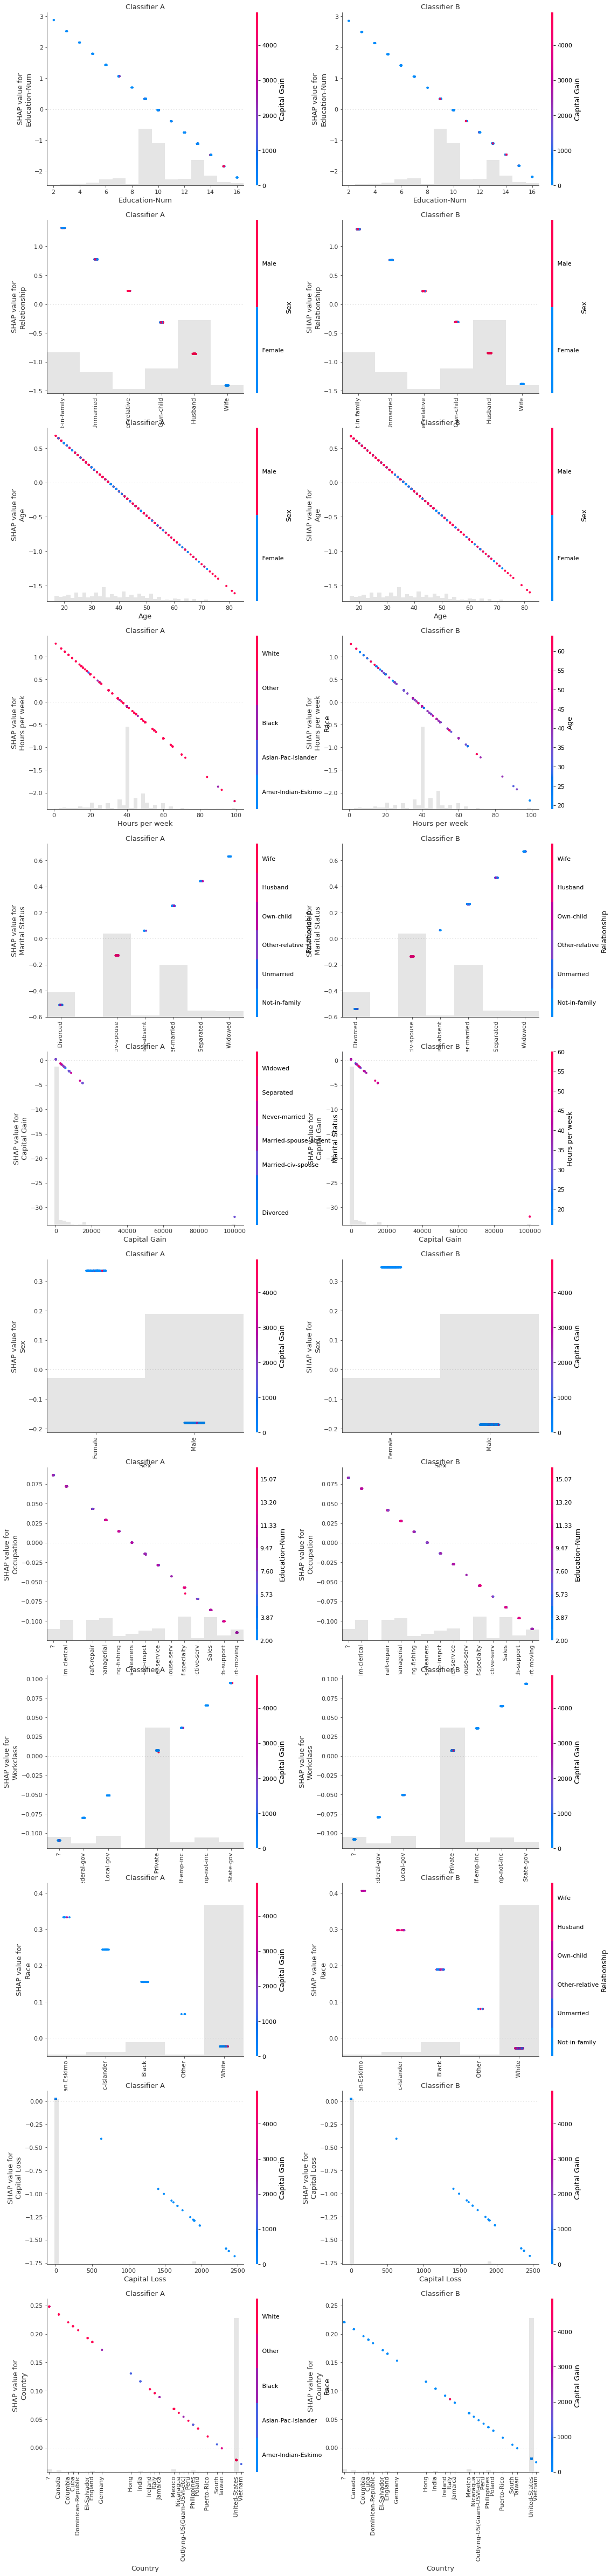

In [28]:
n_columns = 2
n_rows = n_features
fig = pyplot.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in features_sorted:
    ax = fig.add_subplot(n_rows, n_columns, i)
    plot.shap_scatter(expl.log_odds.a, feature, 'Classifier A', ax=ax)
    plot.shap_scatter(expl.log_odds.b, feature, 'Classifier B', ax=fig.add_subplot(n_rows, n_columns, i+1, sharey=ax))
    i += n_columns
pyplot.show()

##### Proposed Approach

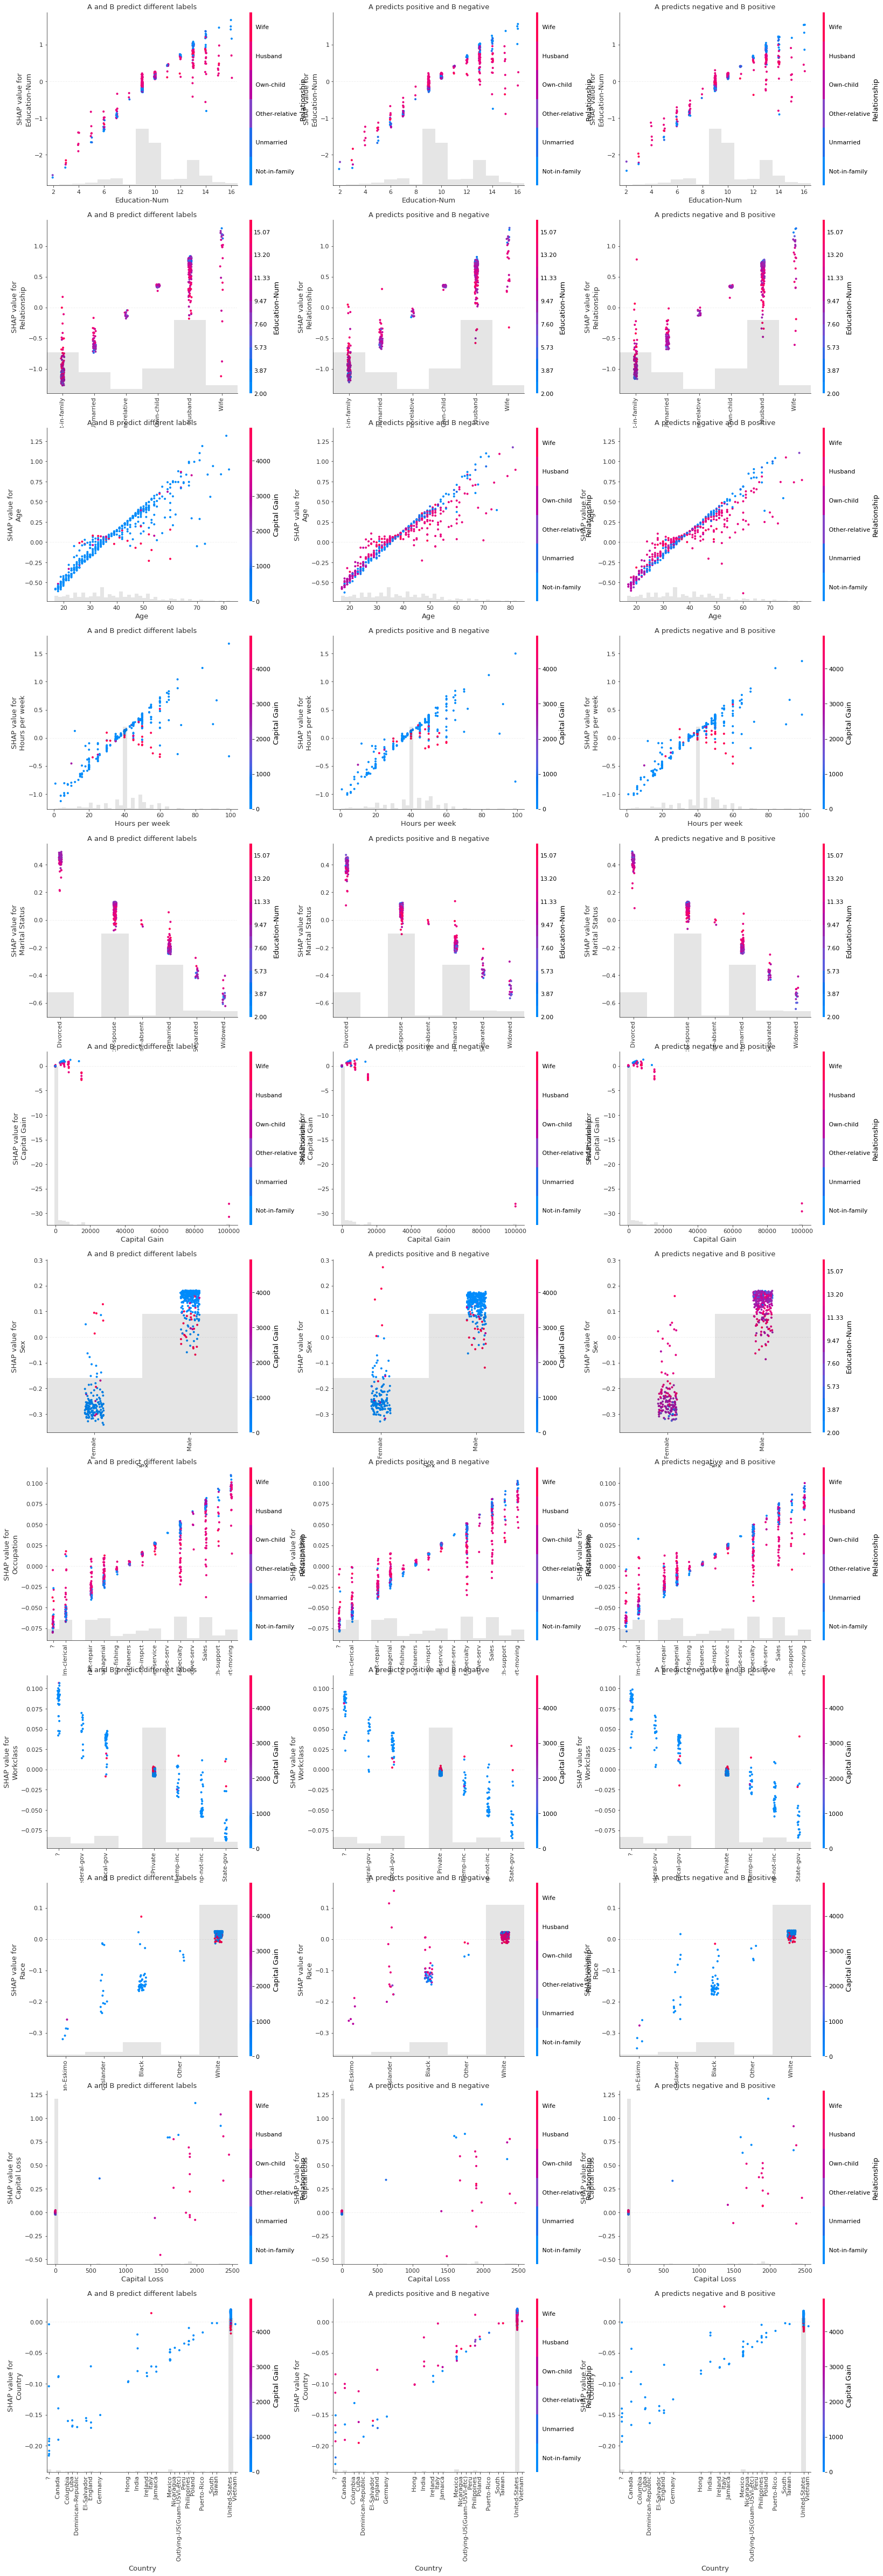

In [29]:
n_columns = 3
n_rows = n_features
fig = pyplot.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in features_sorted:
    ax = fig.add_subplot(n_rows, n_columns, i)
    plot.shap_scatter(expl.log_odds.a_and_b_diff, feature, 'A and B predict different labels', ax=ax)
    plot.shap_scatter(expl.log_odds.a_pos_and_b_neg, feature, 'A predicts positive and B negative', ax=fig.add_subplot(n_rows, n_columns, i+1, sharey=ax))
    plot.shap_scatter(expl.log_odds.a_neg_and_b_pos, feature, 'A predicts negative and B positive', ax=fig.add_subplot(n_rows, n_columns, i+2, sharey=ax))
    i += n_columns
pyplot.show()

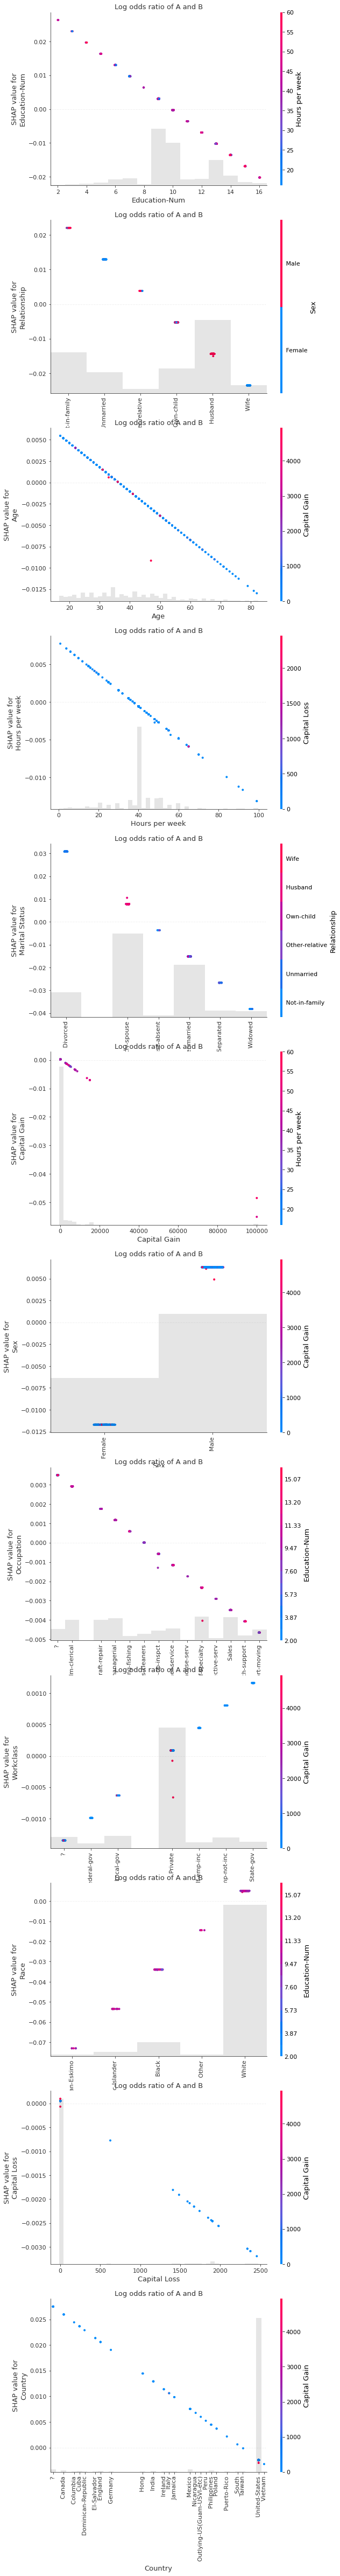

In [30]:
n_columns = 1
n_rows = n_features
fig = pyplot.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in features_sorted:
    ax = fig.add_subplot(n_rows, n_columns, i)
    plot.shap_scatter(expl.log_odds.log_odds_ratio, feature, 'Log odds ratio of A and B', ax=ax)
    i += n_columns
pyplot.show()

### Stacked SHAP Explanations, Clustered by Similarity

#### Probability Space

In [31]:
(indexes,) = np.where(clf.a.predict(X_explain) != clf.b.predict(X_explain))

In [ ]:
X_different = X_explain.iloc[indexes, :]
print(np.array([clf.a.predict_proba(X_different)[:, 1], clf.b.predict_proba(X_different)[:, 1]]))
print(np.array([clf.a.predict_log_odds(X_different)[:, 1], clf.b.predict_log_odds(X_different)[:, 1]]))

In [ ]:
pd.DataFrame(display_data_explain[indexes, :], index=indexes, columns=feature_names)

In [ ]:
for index in indexes:
    plot_shap_values_stacked(expl.proba.a_and_b_diff[index, :], f'A and B different (observation #{index})')

In [ ]:
shap_values = expl.proba.a[clf.a.predict(X_explain) != clf.b.predict(X_explain),:]
shap_values.expected_value = expl.proba.a.expected_value
shap.plots.force(
            base_value=shap_values.base_values[0],
            shap_values=shap_values.values,
            features=shap_values.display_data,
            feature_names=shap_values.feature_names,
            out_names='title')

In [ ]:
shap_values = expl.proba.b[clf.a.predict(X_explain) != clf.b.predict(X_explain),:]
shap_values.expected_value = expl.proba.b.expected_value
shap.plots.force(
            base_value=shap_values.base_values[0],
            shap_values=shap_values.values,
            features=shap_values.display_data,
            feature_names=shap_values.feature_names,
            out_names='title')

In [ ]:
ordering = plot_shap_values_stacked(expl.proba.a, 'Classifier A')
plot_shap_values_stacked(expl.proba.b, 'Classifier B', ordering);

In [ ]:
order = plot_shap_values_stacked(expl.proba.a_and_b_diff, 'A and B predict different labels')
plot_shap_values_stacked(expl.proba.a_pos_and_b_neg, 'A predicts positive and B negative', ordering=order)
plot_shap_values_stacked(expl.proba.a_neg_and_b_pos, 'A predicts negative and B positive', ordering=order);

#### Margin Space

In [ ]:
ordering = plot_shap_values_stacked(expl.log_odds.a, 'Classifier A')
plot_shap_values_stacked(expl.log_odds.b, 'Classifier B', ordering);

In [ ]:
for index in [64, 219]:
    plot_shap_values_stacked(expl.log_odds.a[index, :], f'Classifier A, Observation #{index}')

In [ ]:
plot_shap_values_stacked(expl.log_odds.a_pos_and_b_neg, 'A predicts positive and B negative')
plot_shap_values_stacked(expl.log_odds.a_neg_and_b_pos, 'A predicts negative and B positive')
plot_shap_values_stacked(expl.log_odds.a_and_b_diff, 'A and B predict different labels');

In [ ]:
plot_shap_values_stacked(expl.log_odds.log_odds_ratio, 'Log odds ratio of A and B');

### Hierarchically Clustered SHAP Values

#### Probability Space

In [ ]:
plot_shap_values_hierarchically_clustered(expl.proba.a, 'Classifier A')
plot_shap_values_hierarchically_clustered(expl.proba.b, 'Classifier B')

In [ ]:
plot_shap_values_hierarchically_clustered(expl.proba.a_pos_and_b_neg, 'A predicts positive and B negative')
plot_shap_values_hierarchically_clustered(expl.proba.a_neg_and_b_pos, 'A predicts negative and B positive')
plot_shap_values_hierarchically_clustered(expl.proba.a_and_b_diff, 'A and B predict different labels')

#### Margin Space

In [ ]:
plot_shap_values_hierarchically_clustered(expl.log_odds.a, 'Classifier A')
plot_shap_values_hierarchically_clustered(expl.log_odds.b, 'Classifier B')

In [ ]:
plot_shap_values_hierarchically_clustered(expl.log_odds.a_pos_and_b_neg, 'A predicts positive and B negative')
plot_shap_values_hierarchically_clustered(expl.log_odds.a_neg_and_b_pos, 'A predicts negative and B positive')
plot_shap_values_hierarchically_clustered(expl.log_odds.a_and_b_diff, 'A and B predict different labels')

In [ ]:
plot_shap_values_hierarchically_clustered(expl.log_odds.log_odds_ratio, 'Log odds ratio of A and B')